In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools as it
from mds.mds import mds
from mds.visualizationtools import add_axis_cube, compress_to_sphere
from hopf.hopf import localcoordsampling_2sphere, hopf_inverse_mds

# this is for comparison purposes
from scipy.spatial import distance

# Plots:

In [31]:
def plot_interpolation(x, y, z, point_idxs, cmap='viridis'):
    """
    Plots a 3D scatter plot of points, color-coded by group index with a smooth color progression.
    Additionally, interpolated geodesic lines are drawn, following the original sampling order, with varying line width to enhance depth perception.

    Parameters:
    - x (array-like): x-coordinates of points.
    - y (array-like): y-coordinates of points.
    - z (array-like): z-coordinates of points.
    - point_idxs (array-like): Group index for each point (used for color coding).
    - cmap (str): Colormap to use for the groups (default: 'viridis' for smooth progression).
    """
    x, y, z, point_idxs = map(np.array, (x, y, z, point_idxs))  
    colormap = plt.get_cmap(cmap)
    unique_idxs = np.unique(point_idxs)
    norm = plt.Normalize(vmin=min(unique_idxs), vmax=max(unique_idxs))
    colors = colormap(norm(point_idxs))  
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))
    
    for group in unique_idxs:
        mask = point_idxs == group
        x_group, y_group, z_group = x[mask], y[mask], z[mask]
        
        # Maintain original order (as sampled from geodesic_sample_points)
        if len(x_group) > 1:
            t = np.arange(len(x_group))  
            t_interp = np.linspace(t[0], t[-1], 200)
            x_interp = np.interp(t_interp, t, x_group)
            y_interp = np.interp(t_interp, t, y_group)
            z_interp = np.interp(t_interp, t, z_group)
            
            depth_factor = np.mean(z_group)
            line_width = 1 + (depth_factor - np.min(z)) / (np.max(z) - np.min(z)) * 3  
            
            ax.plot(x_interp, y_interp, z_interp, color=colormap(norm(group)), linewidth=line_width)

    ax.set_title("Fibers of S^3")
    ax.set_axis_off()
    
    plt.show()

def plot_interpolation_sphere(x, y, z, point_idxs, cmap='viridis'):
    """
    Plots a 3D scatter plot of points, color-coded by group index with a smooth color progression.
    Additionally, interpolated geodesic lines are drawn, following the original sampling order, 
    with varying line width to enhance depth perception. A reference sphere with minimal distraction 
    is also drawn to indicate the structure of S^2.

    Parameters:
    - x (array-like): x-coordinates of points.
    - y (array-like): y-coordinates of points.
    - z (array-like): z-coordinates of points.
    - point_idxs (array-like): Group index for each point (used for color coding).
    - cmap (str): Colormap to use for the groups (default: 'turbo' for high contrast).
    """
    x, y, z, point_idxs = map(np.array, (x, y, z, point_idxs))  
    colormap = plt.get_cmap(cmap)
    unique_idxs = np.unique(point_idxs)
    norm = plt.Normalize(vmin=min(unique_idxs), vmax=max(unique_idxs))
    colors = colormap(norm(point_idxs))  
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))

    u = np.linspace(0, np.pi, 200)   
    v = np.linspace(0, 2 * np.pi, 200)  
    u, v = np.meshgrid(u, v)
    sphere_x = np.sin(u) * np.cos(v)
    sphere_y = np.sin(u) * np.sin(v)
    sphere_z = np.cos(u)

    #ax.plot_surface(sphere_x, sphere_y, sphere_z, color='lightgray', alpha=0.15, 
    #                edgecolor='none', linewidth=0, antialiased=True)

    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='black', linewidth=0.2, alpha=0.6)

    for group in unique_idxs:
        mask = point_idxs == group
        x_group, y_group, z_group = x[mask], y[mask], z[mask]
        
        if len(x_group) > 1:
            t = np.arange(len(x_group))  
            t_interp = np.linspace(t[0], t[-1], 300) 
            x_interp = np.interp(t_interp, t, x_group)
            y_interp = np.interp(t_interp, t, y_group)
            z_interp = np.interp(t_interp, t, z_group)
            
            depth_factor = np.mean(z_group)
            line_width = 1.5 + (depth_factor - np.min(z)) / (np.max(z) - np.min(z)) * 3  

            ax.plot(x_interp, y_interp, z_interp, color=colormap(norm(group)), linewidth=line_width, alpha=0.9)

    ax.set_title("Fibers of $S^3$", fontsize=14)
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_zticks([])
    ax.grid(False)
    ax.set_axis_off()

    ax.view_init(elev=150, azim=-100)  

    plt.show()

In [33]:
def spherical_to_cartesian(spherical_points):
    """Convert spherical coordinates (theta, phi) to Cartesian coordinates (x, y, z)."""
    theta, phi = spherical_points[:, 0], spherical_points[:, 1]
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.column_stack((x, y, z))

def plot_sampledpoints(points, pts_index, cmap='viridis'):
    """
    Plots points in 3D space with color mapping based on indices and a high-quality shaded sphere.

    Parameters:
    points (np.ndarray): Array of shape (n, 2) in spherical coordinates (theta, phi).
    pts_index (np.ndarray): Indices used for color mapping.
    cmap (str): Colormap name.
    """
    pts = spherical_to_cartesian(points)  
    point_idxs = np.array(pts_index)

    colormap = plt.get_cmap(cmap)
    norm = plt.Normalize(vmin=point_idxs.min(), vmax=point_idxs.max())
    colors = colormap(norm(point_idxs))  

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1]) 
    #theta
    u = np.linspace(0, np.pi, 100)  
    #phi
    v = np.linspace(0, 2 * np.pi, 100)
    u, v = np.meshgrid(u, v)
    x = np.sin(u) * np.cos(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(u)

    ax.plot_surface(x, y, z, color='lightgray', edgecolor='none', 
                    alpha=0.4, cmap='gray', linewidth=0, antialiased=True)

    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors, marker='o', 
               s=30, edgecolor='black', linewidth=0.5, zorder=10)  

    ax.set_title("Sampled Points on $S^2$", fontsize=14)
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_zticks([])
    ax.grid(False)
    ax.set_axis_off()

    ax.view_init(elev=20, azim=-60)  

    plt.show()

def plot_sampledpoints2(points, pts_index, cmap='viridis'):
    """
    Plots points in 3D space with color mapping based on indices.

    Parameters:
    points (np.ndarray): Array of shape (n, 2) in spherical coordinates (theta, phi).
    pts_index (np.ndarray): Indices used for color mapping.
    cmap (str): Colormap name.
    """
    pts = spherical_to_cartesian(points)  
    point_idxs = np.array(pts_index)

    colormap = plt.get_cmap(cmap)
    norm = plt.Normalize(vmin=point_idxs.min(), vmax=point_idxs.max())
    colors = colormap(norm(point_idxs))  

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1]) 

    u = np.linspace(0, np.pi, 100)
    v = np.linspace(0, 2 * np.pi, 100) 
    u, v = np.meshgrid(u, v)
    x = np.sin(u) * np.cos(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(u)

    ax.plot_surface(x, y, z, color='lightgray', edgecolor='none', 
                    alpha=0.5, cmap='gray', linewidth=0, antialiased=True)

    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors, marker='o', 
                s=50, edgecolor='black', linewidth=0.6, zorder=10, depthshade=False)  

    ax.set_title("Sampled Points on $S^2$", fontsize=14)
    ax.set_xticks([])  
    ax.set_yticks([])  
    ax.set_zticks([])
    ax.grid(False)
    ax.set_axis_off()

    #ax.view_init(elev=20, azim=30)  
    ax.view_init(elev=150, azim=-100)
    plt.show()

**IDEA:**
<br>$(S^3,S^2,\pi,S^1)$ is a fiber bundle, where $\pi : S^3 \to S^2$ being the Hopf
fibration, and for every $p\in S^2, \pi^{-1}(p)=S^1$. The idea is to visualize the fibers corresponding to some points in $S^2$.

- Step 1:
<br>Sample $n$ points in $S^2$ in local coordinates.

- Step 2:
<br>Compute the corresponding fiber of each point, through the inverse of the Hopf fibration.
$$
p=(\theta,\phi)\in S^2,\quad H^{-1}((\theta,\phi))=\{\left(\cos(\frac{\theta}{2}) e^{i\psi}, \sin(\frac{\theta}{2} e^{i(\phi + \psi)})\right), \psi\in[0,2\pi) \}
$$
We can already return $n_{points}$ of the fiber for each point, always the same amount for each fiber,
and in the end have something of this form:
$$
F = \begin{pmatrix}
f_{11} & ... & f_{1n} \\
\vdots & & \vdots\\
f_{d1} & ... & f_{dn}
\end{pmatrix},
$$
where $n$ is the number of points sampled in each fiber and $d$ is the number of
points sampled in $S^2$.

- Step 3: Already automatized in mds function:
<br> Compute distance matrix (symmetric matrix of size $d\cdot n\times d\cdot n$)

$$
D = \begin{pmatrix}
d(f_{11},f_{11}) & ... & d(f_{11},f{1n}) & ... & d(f_{11}, f_{d1}) & ... & d(f_{11},f_{dn}) \\
\vdots & & & & & & \vdots\\
d(f_{dn},f_{11}) & ... & d(f_{dn},f{1n}) & ... & d(f_{dn}, f_{d1}) & ... & d(f_{dn},f_{dn}) 
\end{pmatrix}
$$
<br>Convert distance matrix to B matrix needed as input for mds. Project fibers into
R^3 using mds.

- Step 4: Visualization
<br>Plot points from each fiber the same colour and interpolate.

**EXAMPLES:**

# 1 sampled point

In [4]:
points_1 = localcoordsampling_2sphere(1)
num_samples = 500
fiber_index1, (x1, y1, z1) = hopf_inverse_mds(points_1, num_samples, dimensions_target=3, unravel_coords=True)
# this setting matches the setting from fibers-animate, i.e. it uses cosine distance
#fiber_index1, (x1, y1, z1) = hopf_inverse_mds(points_1, num_samples, dimensions_target=3, unravel_coords=True, distance=distance.cosine)
x1c, y1c, z1c = compress_to_sphere(3, x1, y1, z1)

There are 500 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 498 (99.60%)


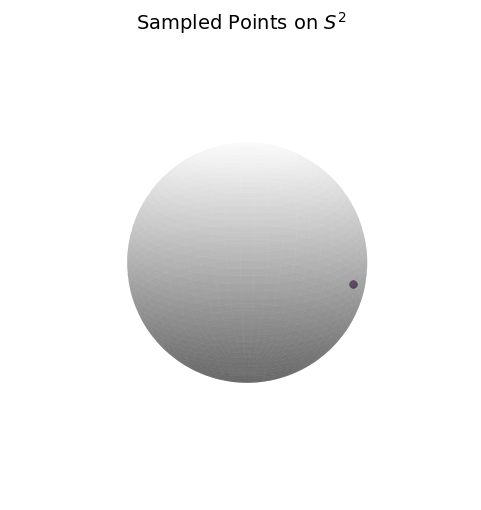

In [5]:
plot_sampledpoints(points_1, [0])

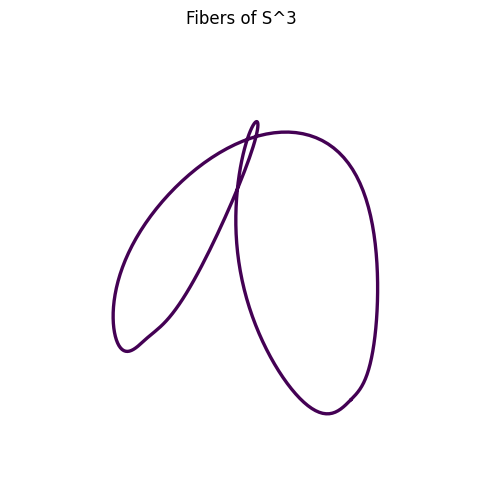

In [6]:
plot_interpolation(x1, y1, z1, fiber_index1)

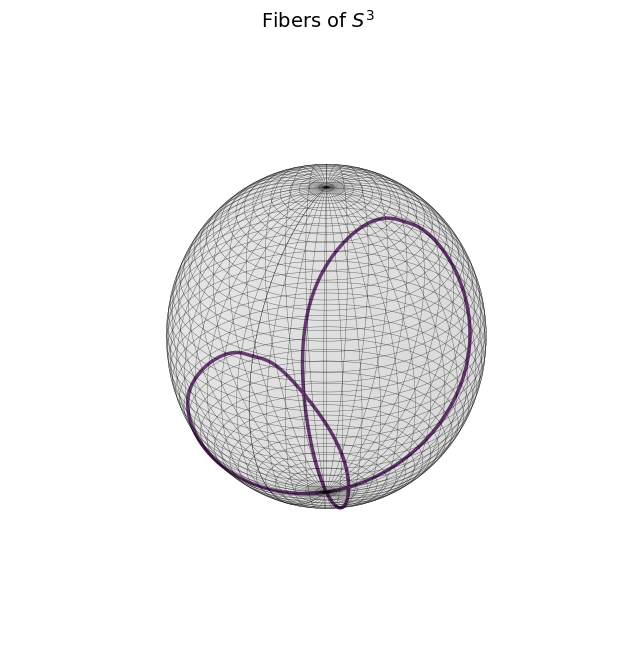

In [7]:
plot_interpolation_sphere(x1c, y1c, z1c, fiber_index1)

# 3 sampled points

In [8]:
points_3 = localcoordsampling_2sphere(3)
num_samples = 500
fiber_index, (x3, y3, z3) = hopf_inverse_mds(points_3, num_samples, dimensions_target=3, unravel_coords=True)
x3c, y3c, z3c = compress_to_sphere(3, x3, y3, z3)

There are 1500 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 1464 (97.60%)


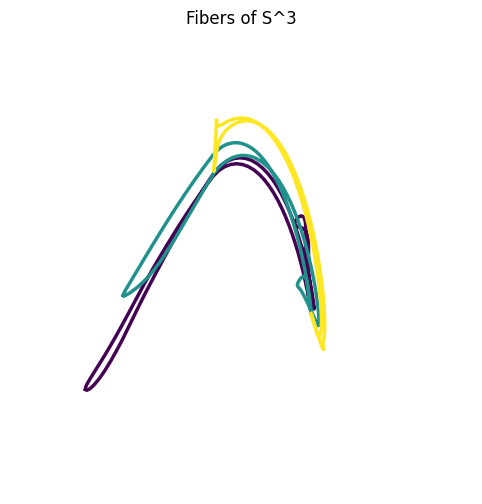

In [9]:
plot_interpolation(x3, y3, z3, fiber_index)

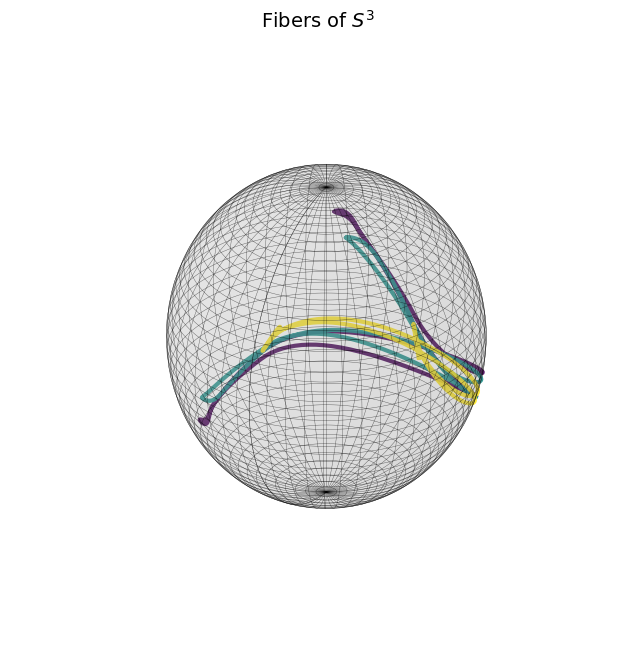

In [10]:
plot_interpolation_sphere(x3c, y3c, z3c, fiber_index)

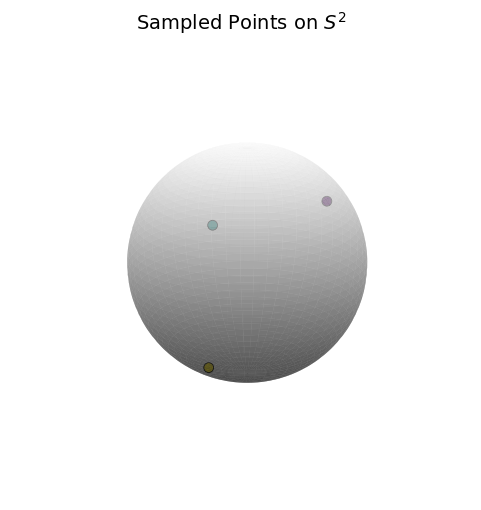

In [11]:
plot_sampledpoints2(points_3, [0,1,2])

# 6 sampled points

In [5]:
points_6 = localcoordsampling_2sphere(6)
num_samples = 500
fiber_index6, (x6, y6, z6) = hopf_inverse_mds(points_6, num_samples, dimensions_target=3, unravel_coords=True)
x6c, y6c, z6c = compress_to_sphere(3, x6, y6, z6)

There are 3000 eigenvalues.
Number of large, non-zero eigenvalues for approximate embedding: 2921 (97.37%)


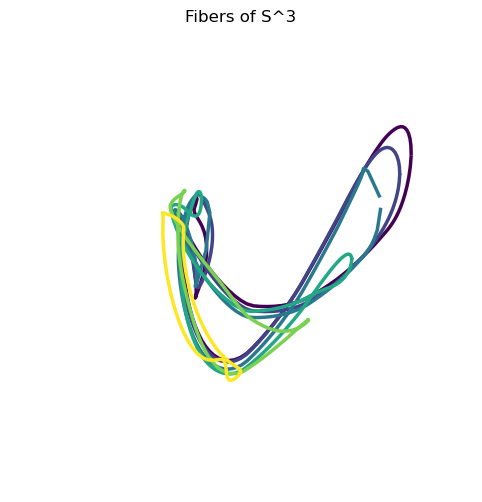

In [19]:
plot_interpolation(x6, y6, z6, fiber_index6)

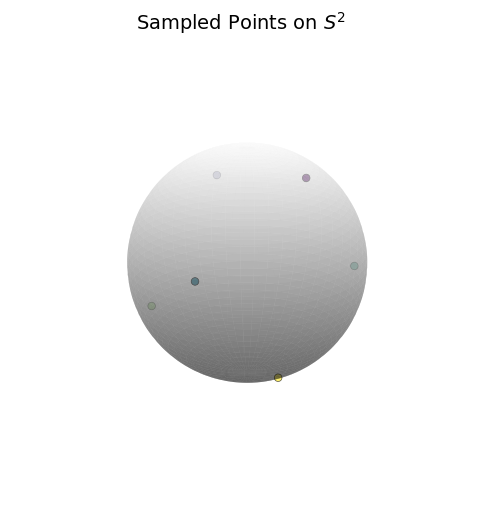

In [34]:
plot_sampledpoints(points_6,[0,1,2,3,4,5])

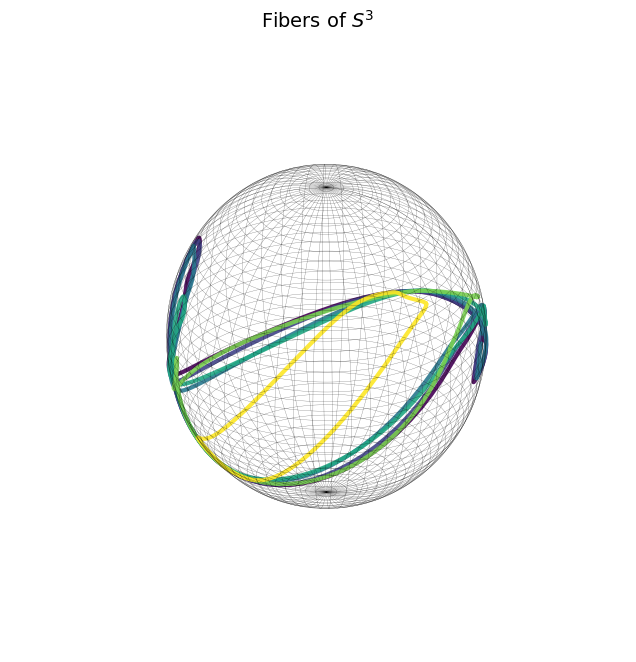

In [ ]:
# view: elev=150, azim=-80
plot_interpolation_sphere(x6c, y6c, z6c, fiber_index6)

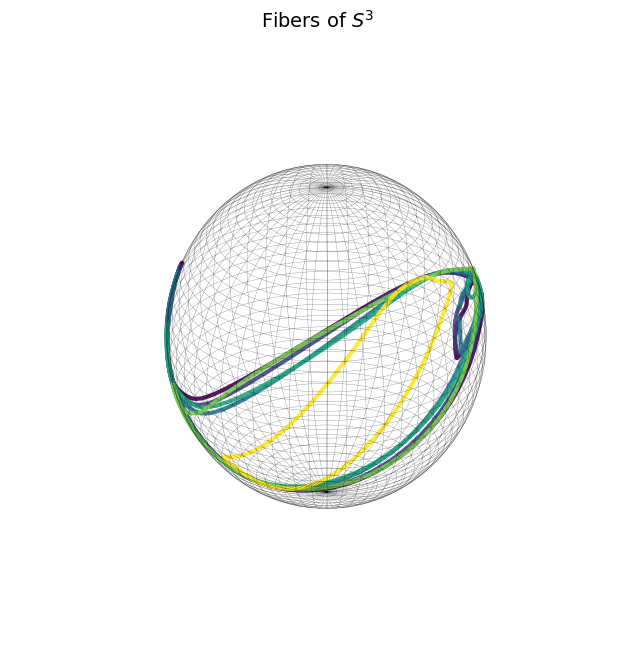

In [ ]:
# view: elev=150, azim=-100
plot_interpolation_sphere(x6c, y6c, z6c, fiber_index6)